image shape
(720, 1280, 3)
mask shape
(720, 1280, 1)


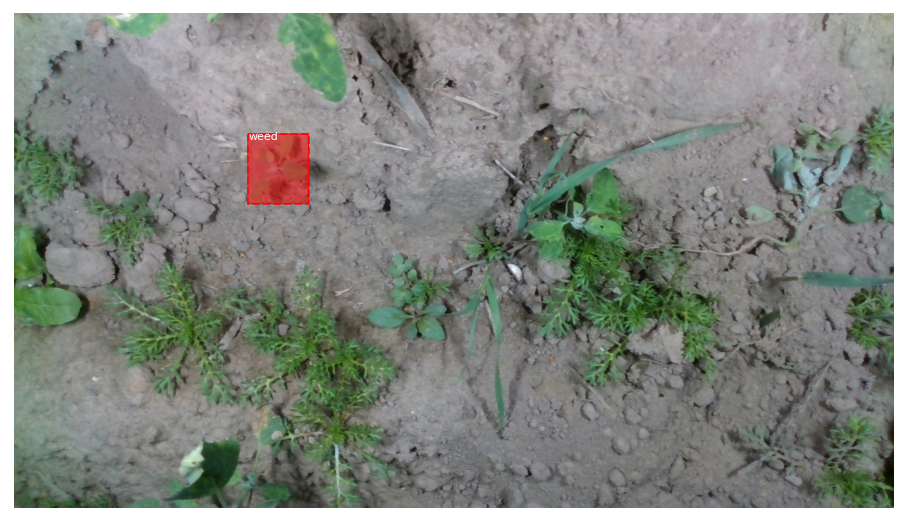

[2]


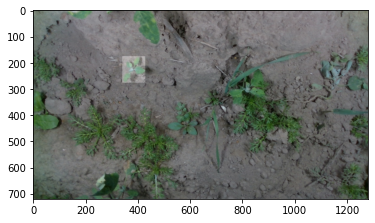

In [8]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
import pdb
import numpy as np
import skimage
from matplotlib import pyplot
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes

#pdb.set_trace()

# class that defines and loads the weed dataset
class WeedDataset(Dataset):
	# load the dataset definitions
	def load_dataset(self, dataset_dir, is_train=True):
		# define two class
		self.add_class("dataset", 1, "crop")
		self.add_class("dataset", 2, "weed")
		# define data locations
		images_dir = dataset_dir + '/raw images/'
		annotations_dir = dataset_dir + '/annotations/'
		
		# find all images
		for filename in listdir(images_dir):
			# extract image id
			image_id = filename[:-4]
			#print('IMAGE ID: ',image_id)
			# skip bad images
			if (image_id == '.ipynb_checkpo'):
				continue
			# skip all images after 115 if we are building the train set
			if is_train and int(image_id) >= 32279:
				continue
			# skip all images before 115 if we are building the test/val set
			if not is_train and int(image_id) < 32279:
				continue
			img_path = images_dir + filename
			ann_path = annotations_dir + image_id + '.xml'
			# add to dataset
			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path, class_ids = [0,1,2])

	# extract bounding boxes from an annotation file
	def extract_boxes(self, filename):
		# load and parse the file
		tree = ElementTree.parse(filename)
		# get the root of the document
		root = tree.getroot()
		# extract each bounding box
		boxes = list()
		#for box in root.findall('.//bndbox'):
		for box in root.findall('.//object'):
			name = box.find('name').text
			xmin = int(box.find('./bndbox/xmin').text)
			ymin = int(box.find('./bndbox/ymin').text)
			xmax = int(box.find('./bndbox/xmax').text)
			ymax = int(box.find('./bndbox/ymax').text)
			#coors = [xmin, ymin, xmax, ymax, name]
			coors = [xmin, ymin, xmax, ymax, name]
			boxes.append(coors)
		# extract image dimensions
		width = int(root.find('.//size/width').text)
		height = int(root.find('.//size/height').text)
		return boxes, width, height

	# load the masks for an image
	def load_mask(self, image_id):
		#pdb.set_trace()
		# get details of image
		info = self.image_info[image_id]
		# define box file location
		path = info['annotation']
		# load XML
		boxes, w, h = self.extract_boxes(path)
		# create one array for all masks, each on a different channel
		masks = zeros([h, w, len(boxes)], dtype='uint8')
		# create masks
		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			if (box[4] == 'crop'):
				masks[row_s:row_e, col_s:col_e, i] = 2
				class_ids.append(self.class_names.index('crop'))
			else:
				masks[row_s:row_e, col_s:col_e, i] = 1
				class_ids.append(self.class_names.index('weed'))
			
				
		return masks, asarray(class_ids, dtype='int32')

	# load an image reference
	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']
train_set = WeedDataset()
train_set.load_dataset('Ronin_OPEN_DB', is_train=True)
train_set.prepare()
# load an image
image_id = 0
image = train_set.load_image(image_id)
print('image shape')
print(image.shape)
# load image mask
mask, class_ids = train_set.load_mask(image_id)
print('mask shape')
print(mask.shape)
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)
# plot image
pyplot.imshow(image)
# plot mask
for j in range(mask.shape[2]):
	pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.2)
print(class_ids)
pyplot.show()

In [7]:
for image_id in train_set.image_ids:
	# load image info
	info = train_set.image_info[image_id]
	# display on the console
	print(info)

{'id': '00000', 'source': 'dataset', 'path': 'sample_dataset/images/00000.jpg', 'annotation': 'sample_dataset/annots/00000.xml', 'class_ids': [0, 1, 2]}
{'id': '00001', 'source': 'dataset', 'path': 'sample_dataset/images/00001.jpg', 'annotation': 'sample_dataset/annots/00001.xml', 'class_ids': [0, 1, 2]}
{'id': '00002', 'source': 'dataset', 'path': 'sample_dataset/images/00002.jpg', 'annotation': 'sample_dataset/annots/00002.xml', 'class_ids': [0, 1, 2]}
{'id': '00003', 'source': 'dataset', 'path': 'sample_dataset/images/00003.jpg', 'annotation': 'sample_dataset/annots/00003.xml', 'class_ids': [0, 1, 2]}
{'id': '00004', 'source': 'dataset', 'path': 'sample_dataset/images/00004.jpg', 'annotation': 'sample_dataset/annots/00004.xml', 'class_ids': [0, 1, 2]}
{'id': '00005', 'source': 'dataset', 'path': 'sample_dataset/images/00005.jpg', 'annotation': 'sample_dataset/annots/00005.xml', 'class_ids': [0, 1, 2]}
{'id': '00006', 'source': 'dataset', 'path': 'sample_dataset/images/00006.jpg', 'a